In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *
from tabulate import tabulate

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
InfoMat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.csv", index_col=0)
adj_mat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/WeightMat.Ipsi.csv", index_col=0)

InfoMat_short = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.short.csv", index_col=0)

InfoMat_long = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.long.csv", index_col=0)

In [4]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)

def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES

def LoadSA3(fname, DIR, InfoMat, minbias, topL=100):
    fin = open(DIR+fname, 'rt')
    max_score, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        if bias < minbias:
            continue
        STRs = l[2].split(",")
        score = ScoreCircuit_SI_Joint(STRs, InfoMat)
        if score > max_score:
            max_score = score
            max_bias = bias
            max_STRs = STRs
    return max_score, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat, InfoMat):
    SCORES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        score, real_minbias, STRs = LoadSA3(fil, DIR, InfoMat, row["bias"])
        score = ScoreCircuit_SI_Joint(STRs, InfoMat)
        if score == 0:
            continue
        SCORES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return SCORES, CutBias, RealBias, STRS

def XXXX_cont(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, InfoMat):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    SCORES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, InfoMat)
    New_RealBias = []
    for STRSET in STRS:
        xx = BiasDF.loc[STRSET, "EFFECT"].mean()
        New_RealBias.append(xx)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_SI_Joint(topNSTRs, InfoMat)
    SCORES.append(score)
    CutBias.append(bias)
    New_RealBias.append(bias)
    STRS.append(topNSTRs)    
    return SCORES, CutBias, New_RealBias, STRS

def search_target_swap(size, BiasDF, NSwap, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        NDiff = len(set(STRs).difference(topNSTRs))
        if abs(NDiff-NSwap) < 2:

            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score > 0.714:
                #print(RegionDistributionsList(STRs))
                print(score, score1, score2)
            return bias, score, score1, score2
    return None, None, None, None

def search_target_swap2(size, BiasDF, biaslim, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        #print(round(real_minbias,3), biaslim)
        if round(real_minbias,3) == biaslim:
            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score2 > 0.673:
                #print()
                print(RegionDistributionsList(STRs))
            return bias, score, score1, score2
    return None, None, None, None

def LoadProfiles(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, InfoMat):
    Scores, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, InfoMat)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF2.head(size)["EFFECT"].mean()
    score = ScoreCircuit_SI_Joint(topNSTRs, InfoMat)
    Scores.append(score)
    CutBias.append(bias)
    RealBias.append(bias)
    STRS.append(topNSTRs)    
    return Scores, CutBias, RealBias, STRS

# Plot ASD vs Sibling Profiles

In [5]:
size = 46
#biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_SI_v2_Size46_Nov2023/"
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])
COHESPeak, CutBiasPeak, RealBiasPeak, STRSPeak = LoadProfiles(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                              ASD_DIR, adj_mat, InfoMat)
ASD_DFPeak = pd.DataFrame(data={"Cohe":COHESPeak, "minBias":CutBiasPeak, "Bias":RealBiasPeak})


In [6]:
print(RegionDistributionsList(STRSPeak[-3]))

Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Midbrain	1	Anterior_pretectal_nucleus
Hippocampus	6	Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Field_CA3; Entorhinal_area_lateral_part
Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Gustatory_areas; Agranular_insular_area_ventral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Cortical_subplate	2	Claustrum; Endopiriform_nucleus_dor

In [7]:
print(RegionDistributionsList(STRSPeak[-4]))

Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Midbrain	1	Anterior_pretectal_nucleus
Hippocampus	6	Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Subiculum_dorsal_part; Entorhinal_area_lateral_part
Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Gustatory_areas; Agranular_insular_area_ventral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Cortical_subplate	2	Claustrum; Endopiriform

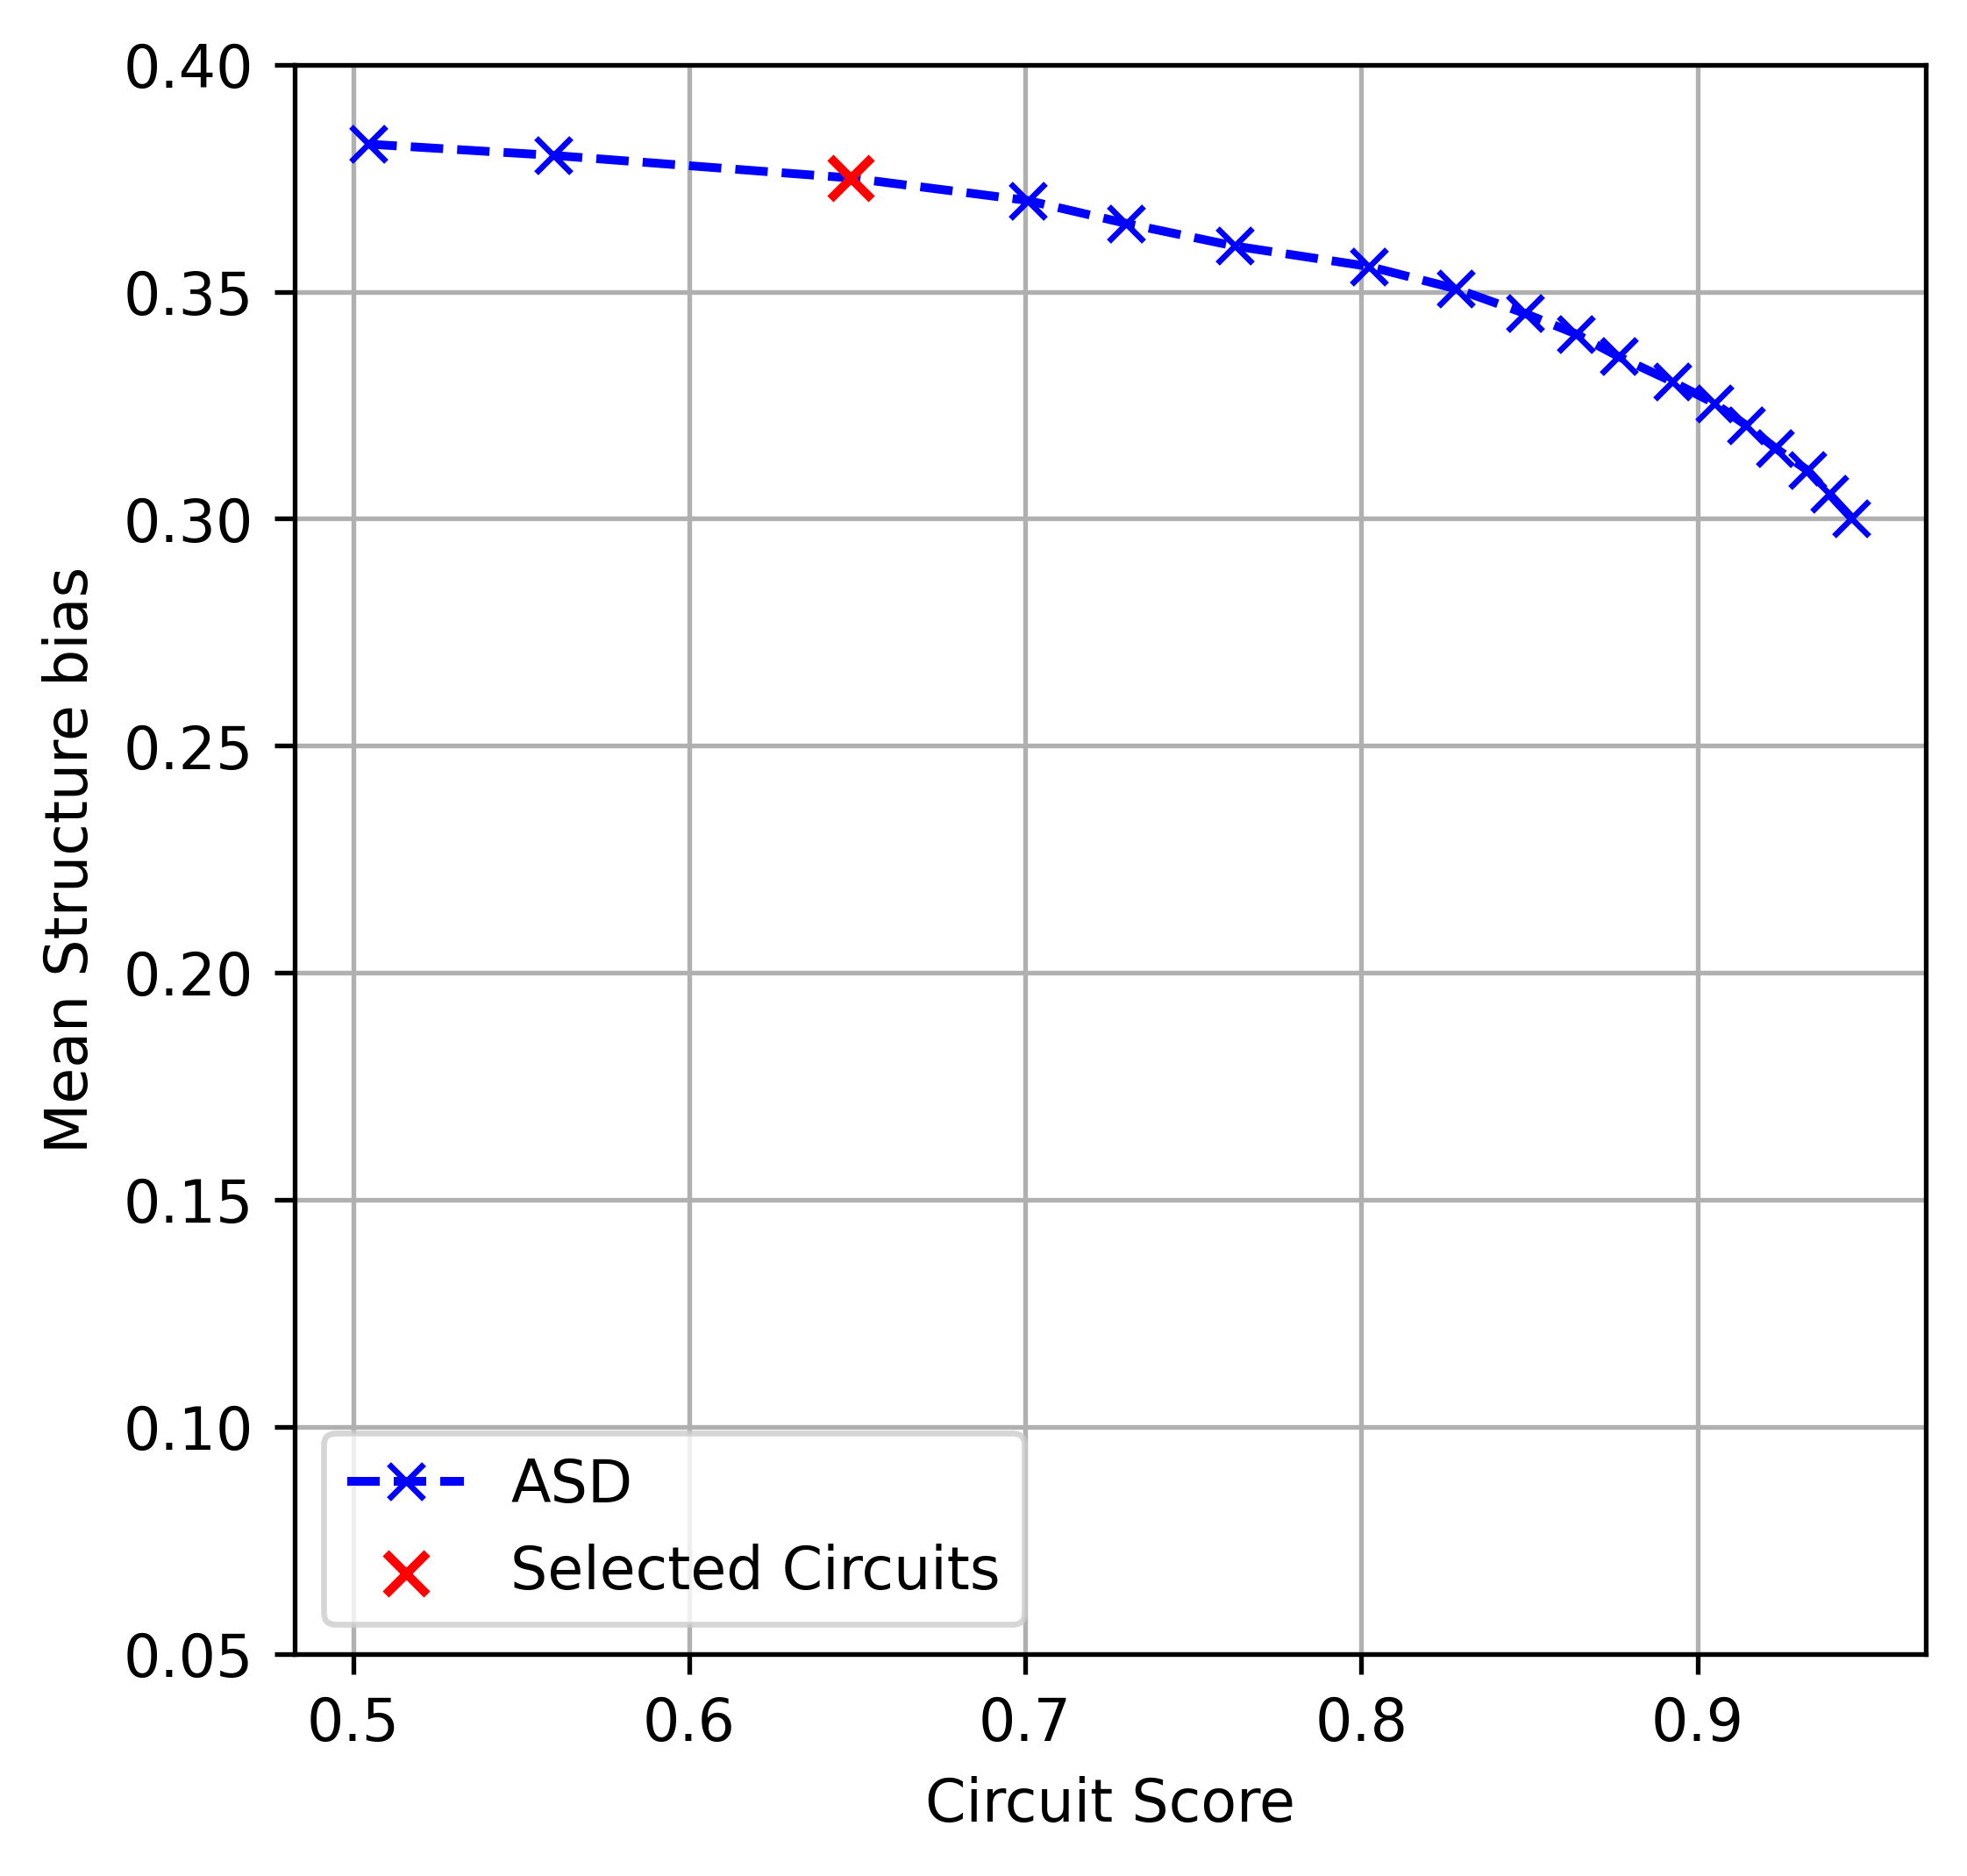

In [8]:
plt.figure(dpi=480, figsize=(5,5))
plt.plot(ASD_DFPeak["Cohe"].values, ASD_DFPeak["Bias"].values, marker="x", color="blue",
             ls = "--", label="ASD")
plt.scatter(ASD_DFPeak["Cohe"].values[-3], ASD_DFPeak["Bias"].values[-3], marker="x", s=50, color="red",
           zorder=100, label="Selected Circuits")
#plt.plot(SIB_DF55["Cohe"].values[3:], SIB_DF55["Bias"].values[3:], marker="x", color="orange",
#             ls = "--", label="Sibling")
plt.xlabel("Circuit Score")
plt.ylabel("Mean Structure bias")
plt.grid()
plt.ylim((0.05, 0.4))
plt.legend()

# Plt with Random Genes

In [9]:
size = 46

biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])


SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_Score_SI_Nov27_2023/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"

dat_score = []
dat_bias = []

for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    #try:
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        biasdf = SIB_BIAS_DIR + file + ".csv"
        Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")
        try:
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            COHES55, CutBias55, RealBias55, STRS55 = XXXX_cont(Sib_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                          ASD_cont_Dir, adj_mat, InfoMat)
            dat_score.append(COHES55)
            dat_bias.append(RealBias55)
        except:
            continue

/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/

/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2918: RuntimeWarning: invalid value encountered in double_scalars
  return score/N_events
/home/jw3514/

In [10]:
dat_score = np.array(dat_score)
dat_score_flat = dat_score.flatten()
dat_bias = np.array(dat_bias)
dat_bias_flat = dat_bias.flatten()

In [11]:
Sib_DF55 = pd.DataFrame(data={"SI score":dat_score_flat, "Bias":dat_bias_flat})

In [12]:
Sib_DF55.shape

(18000, 2)

In [13]:
profiles = []
for bias, score in zip(dat_bias, dat_score):
    meanbias = np.mean(bias)
    meanscore = np.mean(score)
    meantotal = meanbias + meanscore
    profiles.append([meanbias, meanscore, meantotal, bias, score])

In [14]:
rank_bias = sorted(profiles, key = lambda x:x[0], reverse=True)
rank_score = sorted(profiles, key = lambda x:x[1], reverse=True)

In [15]:
topbias = []
for i in range(len(profiles)):
    topbias.append((rank_bias[i][4], rank_bias[i][3]))
topbias = np.array(topbias)
topSI = []
for i in range(len(profiles)):
    topSI.append((rank_score[i][4], rank_score[i][3]))
topSI = np.array(topSI)

In [16]:
topbias.shape

(1000, 2, 18)

In [17]:
topbias[1,0,:]

array([0.70714632, 0.68659069, 0.66790652, 0.65179786, 0.63029635,
       0.59930802, 0.59152741, 0.56863317, 0.5441362 , 0.52015338,
       0.49671589, 0.46679134, 0.44810033, 0.42091556, 0.37986303,
       0.34888227,        nan, 0.23560977])

In [18]:
# Moving AVG
meanbias = []
meanSI = []
xerr = []
yerr = []
for i in range(topbias.shape[2]):
    meanbias.append(np.nanmean(topbias[:,1,i]))
    meanSI.append(np.nanmean(topbias[:,0,i]))
    xerr.append(topbias[:,0,i].std())
    yerr.append(topbias[:,1,i].std())

In [19]:
topbias.shape

(1000, 2, 18)

In [44]:
# subsample subsample sibs
#rand_indexes = np.random.randint(0, topbias.shape[0], topbias.shape[0])
rand_indexes = np.random.randint(0, topbias.shape[0], 1000)
topbias_sub = topbias[rand_indexes]

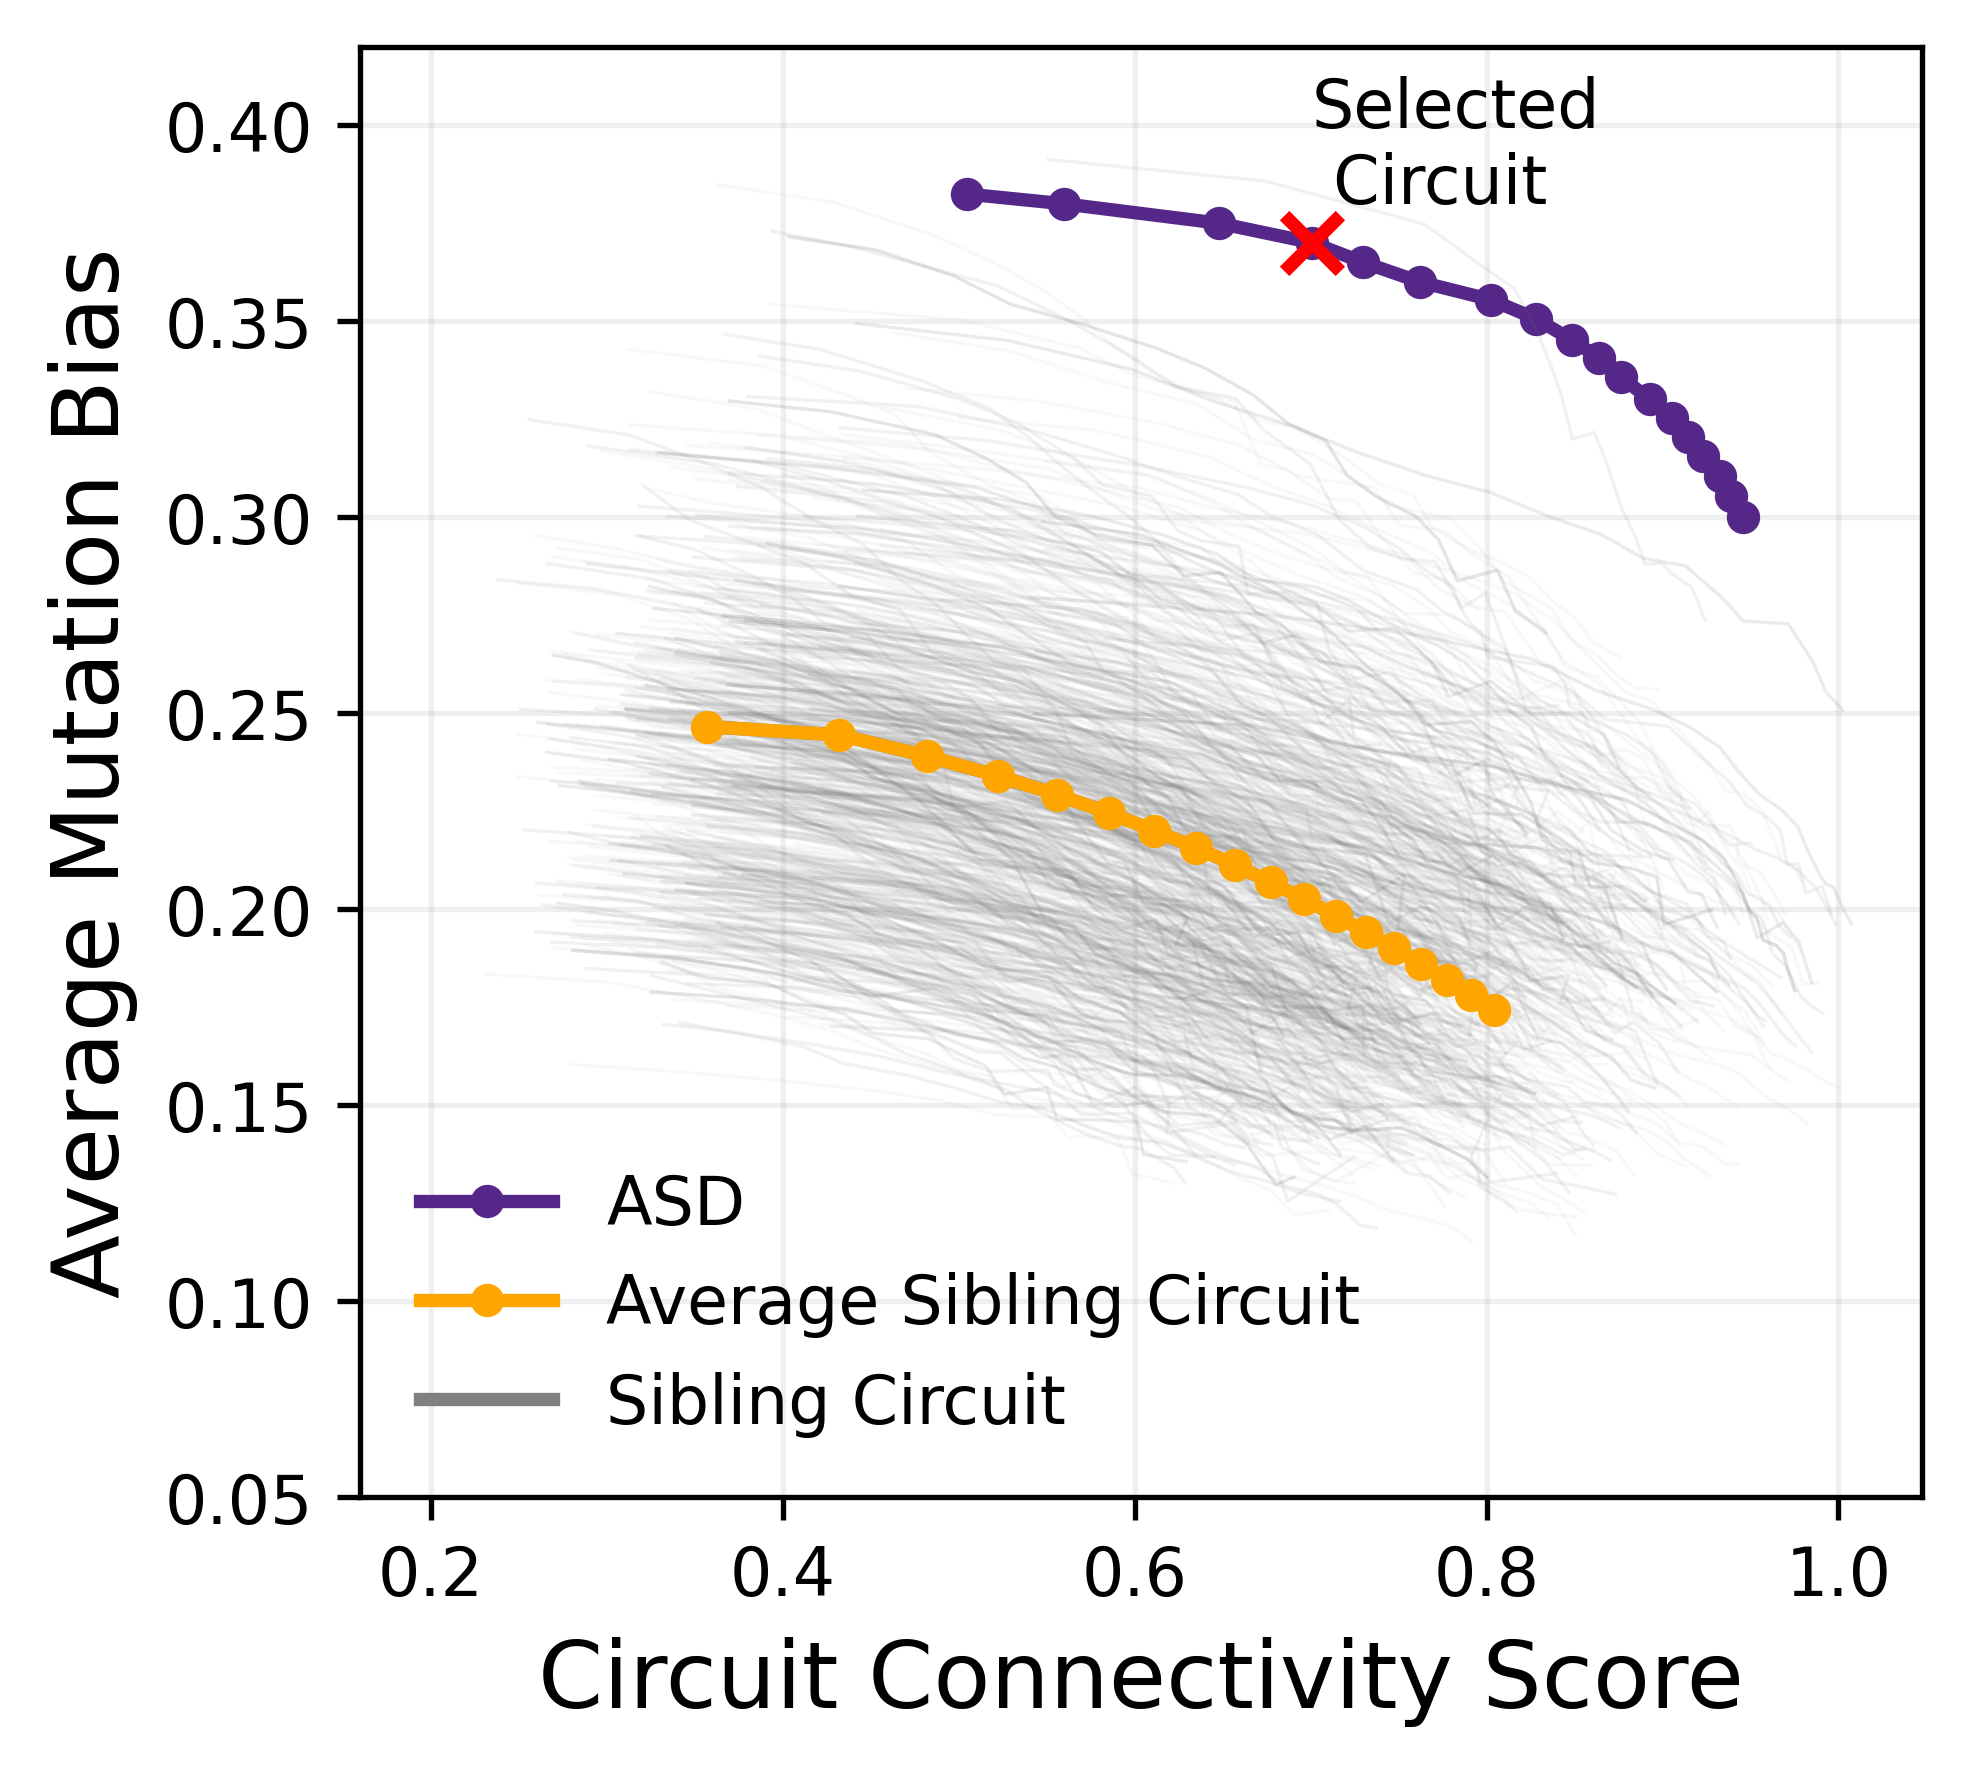

In [68]:
fig, ax = plt.subplots(dpi=480, figsize=(4.2,4))

ax.plot(ASD_DFPeak["Cohe"].values, ASD_DFPeak["Bias"].values, marker=".", color="#542788",  lw=2, markersize=8,
             ls = "-", label="ASD")
ax.scatter(ASD_DFPeak["Cohe"].values[-4], ASD_DFPeak["Bias"].values[-4], marker="x", s=70, color="red", lw=2,
           zorder=100)
ax.text(ASD_DFPeak["Cohe"].values[-4], 0.01 + ASD_DFPeak["Bias"].values[-4], s="Selected\n Circuit")

ax.plot(topbias_sub[:,0,:].T, topbias_sub[:,1,:].T, color="grey", markersize=1, lw=0.5,
             ls = "-", alpha=0.05)
#ax.plot(topbias_sub[0,0,:].T, topbias_sub[0,1,:].T, color="grey", markersize=1, lw=1,
#             ls = "-", alpha=1, label="Sibling Circuit")

ax.plot(meanSI, meanbias, marker=".", color="Orange", lw=2, markersize=8,
             ls = "-", alpha=1, label="Average Sibling Circuit")
ax.plot(meanSI, meanbias, color="grey", lw=2, markersize=8,
             ls = "-", alpha=1, label="Sibling Circuit", zorder=0)

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc="center left", bbox_to_anchor=(1, 0.9))
ax.legend(loc="lower left", frameon=False)

plt.xlabel("Circuit Connectivity Score", fontsize=14)
plt.ylabel("Average Mutation Bias", fontsize=14)
plt.grid(True, alpha=0.2)
plt.ylim(0.05, 0.42)

plt.show()

In [22]:
3/2000

0.0015

In [24]:
4/500

0.008

In [100]:
# mean profile w error bars
yerr

[0.026335674209845762,
 0.026704020368129862,
 0.02706326834274354,
 0.027515333143070142,
 0.02810525482979377,
 0.028670913078938924,
 0.029289147576084675,
 0.02989153227794692,
 0.030486008058277263,
 0.031091455645608033,
 0.03173773224663107,
 0.03239852143375121,
 0.03308665845666544,
 0.033778763051365235,
 0.03448054458999604,
 0.03522690526134134,
 0.036043785503641915,
 0.03648657812816678]

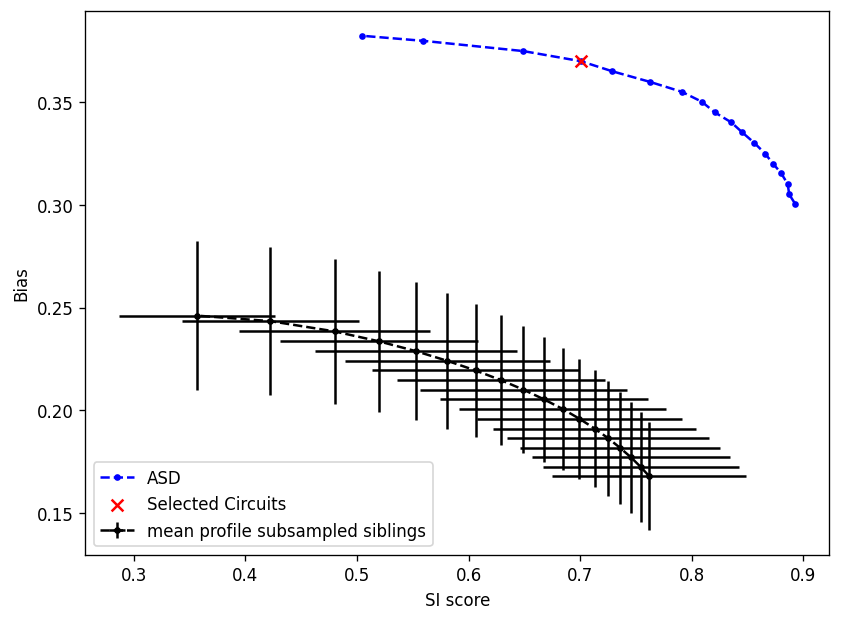

In [102]:
plt.figure(dpi=120, figsize=(8,6))

plt.plot(ASD_DFPeak["Cohe"].values, ASD_DFPeak["Bias"].values, marker=".", color="blue",
             ls = "--", label="ASD")
plt.scatter(ASD_DFPeak["Cohe"].values[-4], ASD_DFPeak["Bias"].values[-4], marker="x", s=50, color="red",
           zorder=100, label="Selected Circuits")


plt.errorbar(meanSI, meanbias, xerr=xerr, yerr=yerr, marker=".", color="black",
             ls = "--", alpha=1, label="mean profile subsampled siblings")

plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')

plt.xlabel("SI score")
plt.ylabel("Bias")

plt.show()

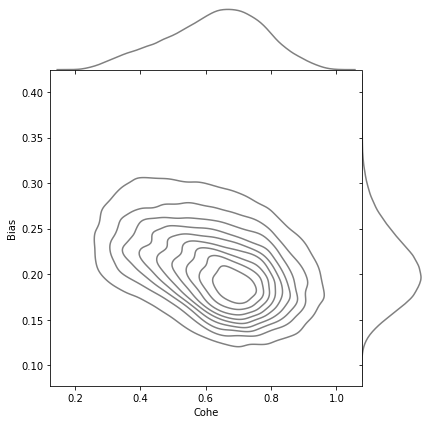

In [20]:
sns.jointplot(x=Sib_DF55["Cohe"], y=Sib_DF55["Bias"], 
              kind='kde', color="grey", space=0)
plt.show()

In [ ]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/Sim_ScoreInfo_Oct12//"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/RandGene.61.W1/"

counts = 0
for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        #print(d)
        
        try:
            biasdf = SIB_BIAS_DIR + file + ".csv"
            Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                    adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                    ProbMat2, ProbMat2_short, ProbMat2_long, ASD_cont_Dir)
            #if score2 > Score_ASD_Long:
            #    print("--" + file)
            #print(cohe)
            if score != None:
                SCORES.append(score)
                SCORES_Short.append(score1)
                SCORES_Long.append(score2)
                Biases.append(bias)
            else:
                print(file, "Fail to find proper circuits")
        except:
            print(file, "Fail to process")
        
    counts += 1
    #if counts > 10 :
    #    break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

In [14]:
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

(1.5956073772483796, 0.06344827586206891)
(0.12129691302896452, 0.4427586206896552)
(2.105938335090527, 0.0289655172413793)


<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

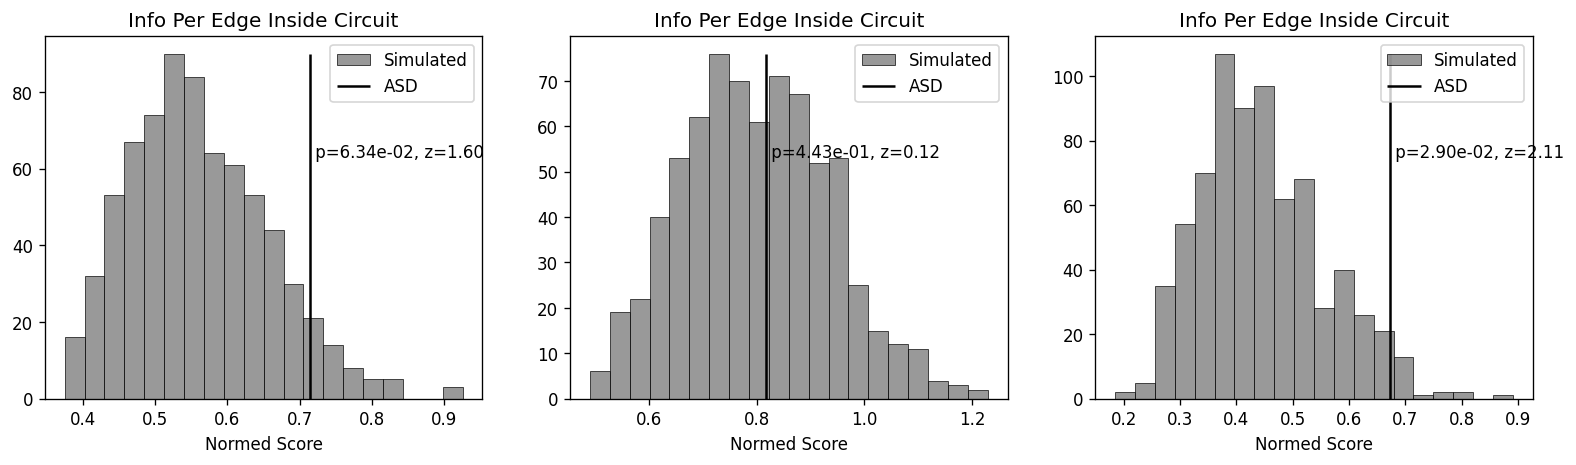

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Simulated", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Simulated", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Simulated", bar_label="ASD")

In [16]:
len(SCORES_Long)

724

# Plt with SubSample Sib (Not Use)

/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events

cont.bias.1.0 Fail to process


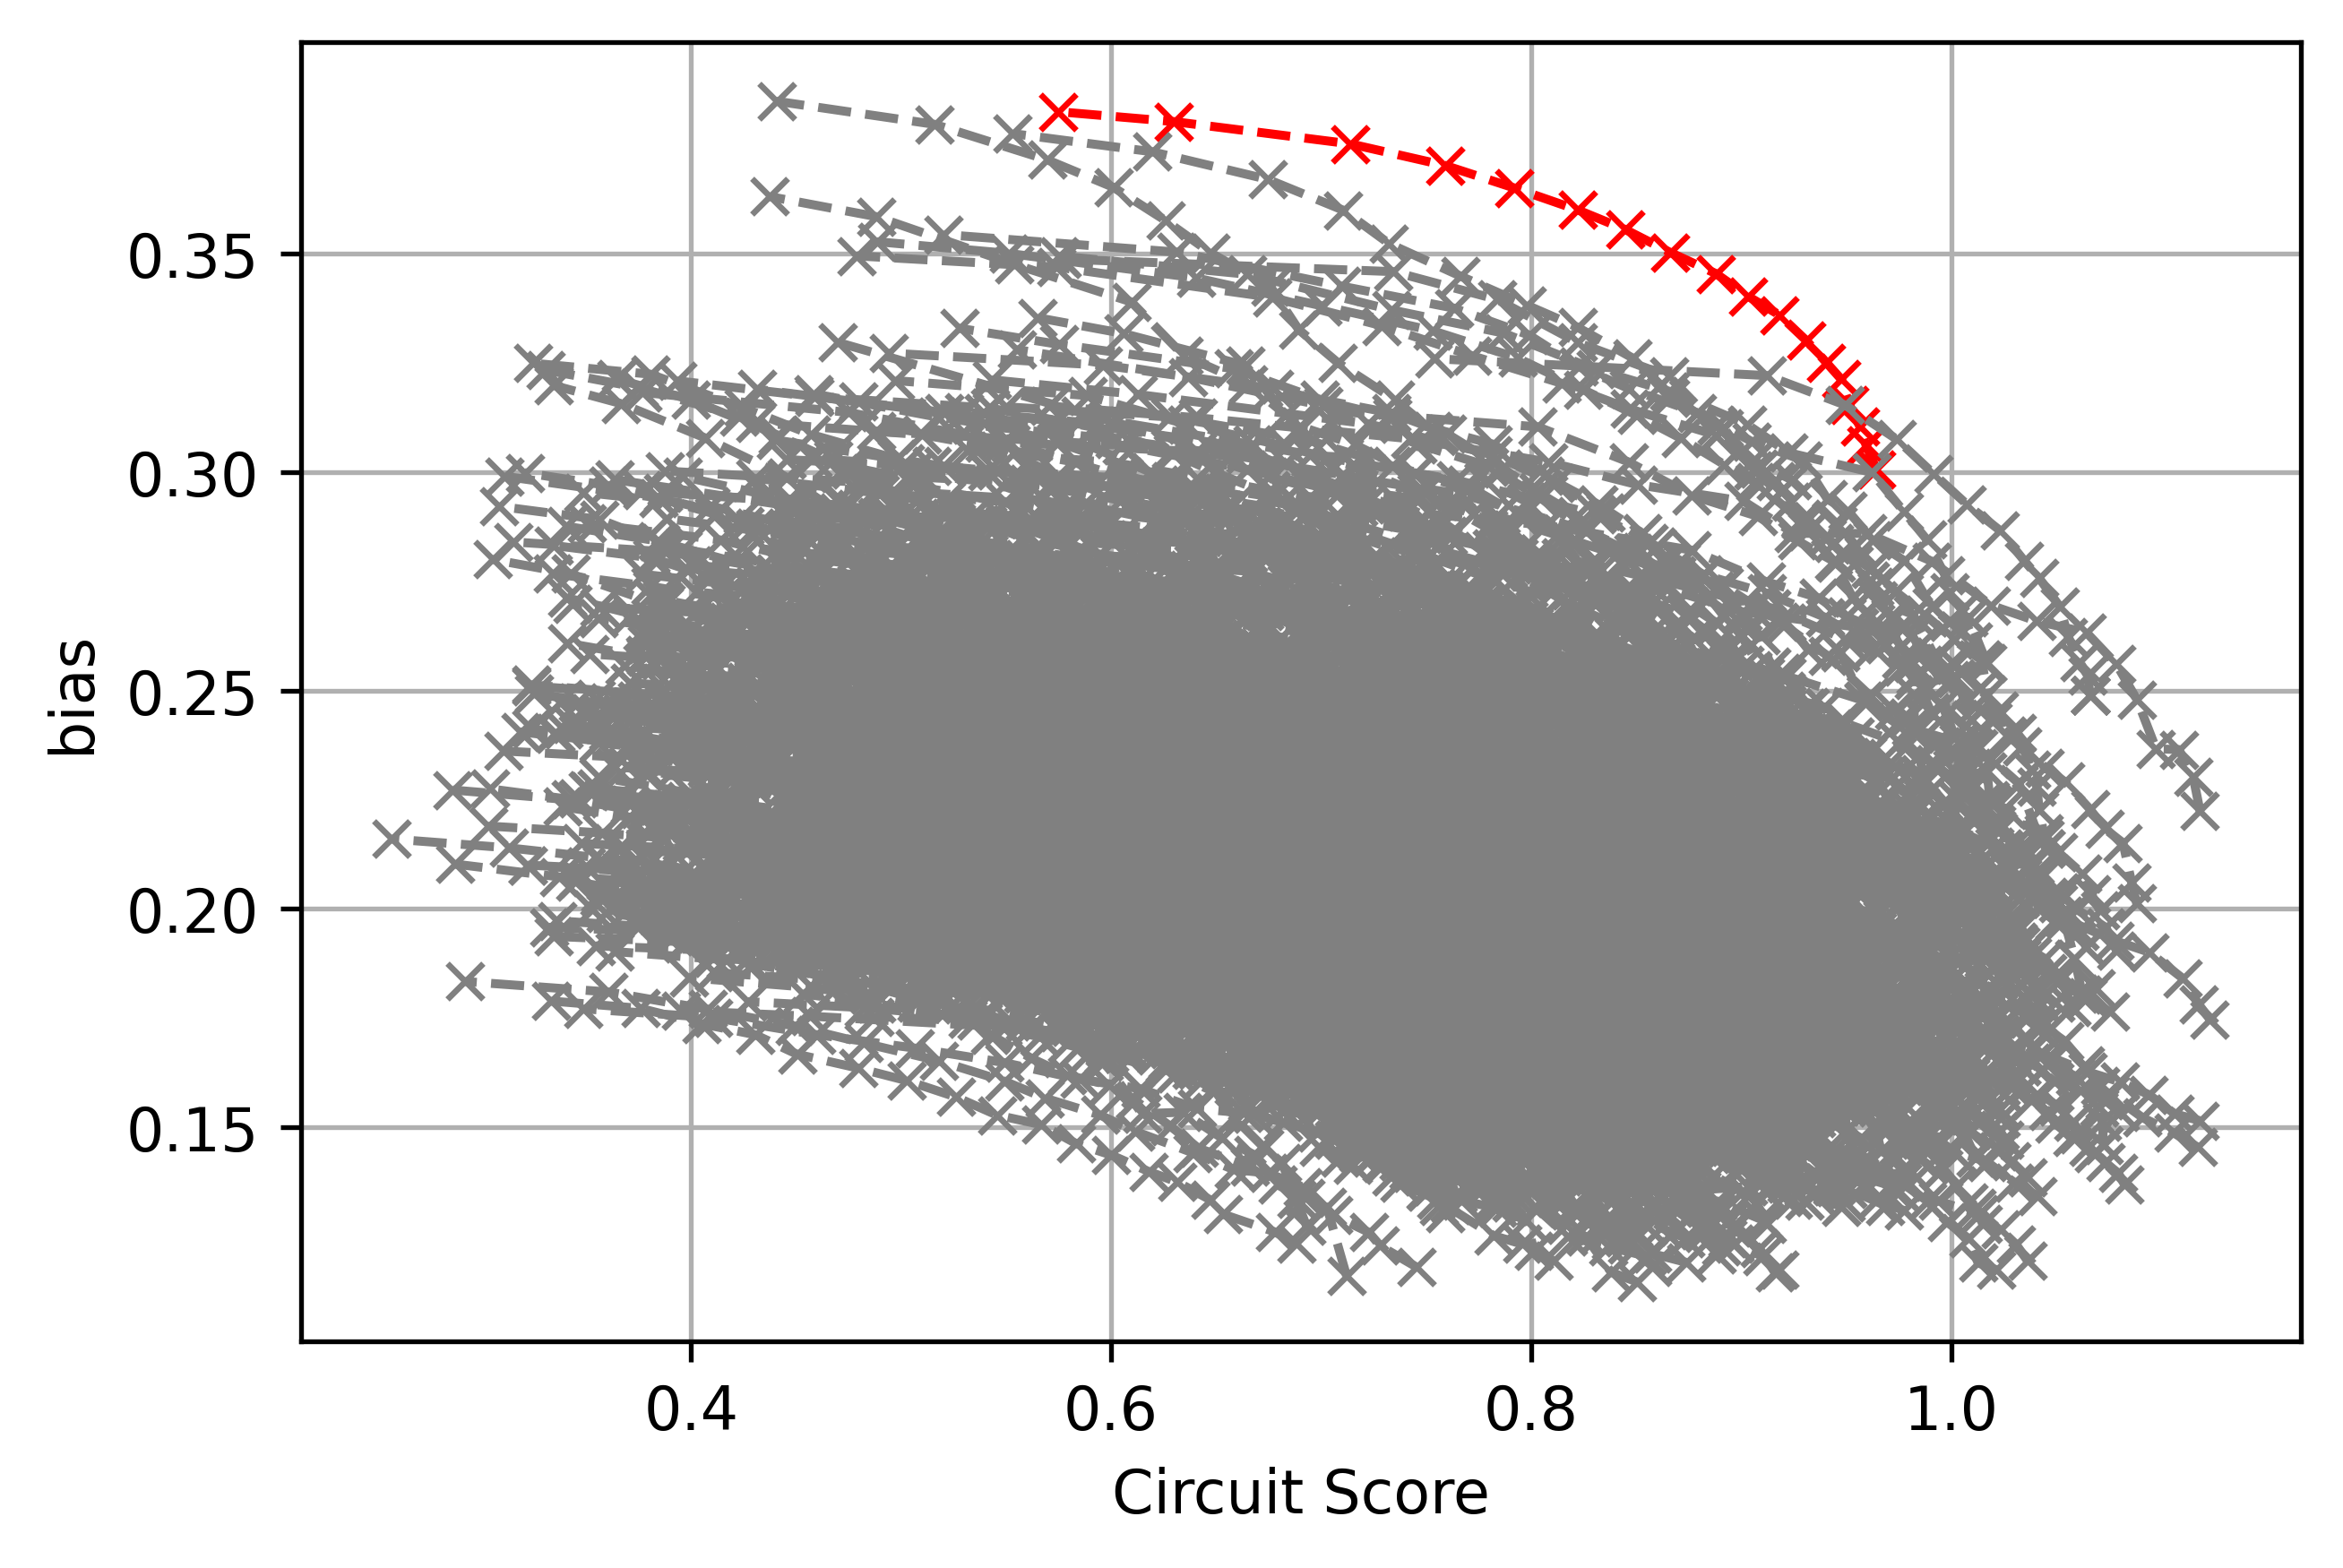

In [44]:
size = 46

biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])

plt.figure(dpi=480)
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values, marker="x", color="red",
             ls = "--", label="bias")

SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Sep02/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"

for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    try:
        d = os.path.join(SIB_SA_DIR, file)
        if os.path.isdir(d):
            biasdf = SIB_BIAS_DIR + file + ".csv"
            Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            COHES55, CutBias55, RealBias55, STRS55 = XXXX_cont(Sib_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                          ASD_cont_Dir, adj_mat, ProbMat1, ProbMat2)
            Sib_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
            plt.plot(Sib_DF55["Cohe"].values, Sib_DF55["Bias"].values, marker="x", color="gray",
                     ls = "--")
    except:
        print(file, "Fail to process")
plt.grid(True)
#plt.ylim((0.28, 0.39))
#plt.legend()
plt.xlabel("Circuit Score")
plt.ylabel("bias")
plt.savefig("../figs/ASD_Circuits.Pareto.46.cont.33.pdf")

In [45]:
print(i)

563


In [47]:
10000 / 500 * 3

60.0

In [40]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Sep02/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"

counts = 0
for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        #print(d)
        
        try:
            biasdf = SIB_BIAS_DIR + file + ".csv"
            Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                    adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                    ProbMat2, ProbMat2_short, ProbMat2_long, ASD_cont_Dir)
            #if score2 > Score_ASD_Long:
            #    print("--" + file)
            #print(cohe)
            if score != None:
                SCORES.append(score)
                SCORES_Short.append(score1)
                SCORES_Long.append(score2)
                Biases.append(bias)
            else:
                print(file, "Fail to find proper circuits")
        except:
            print(file, "Fail to process")
        
    counts += 1
    #if counts > 10 :
    #    break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

cont.bias.11.75 Fail to find proper circuits
cont.bias.10.96 Fail to find proper circuits
cont.bias.13.41 Fail to find proper circuits
0.7224916886824394 0.7306936759537245 0.7106249836941971
cont.bias.100.22 Fail to find proper circuits
cont.bias.12.56 Fail to find proper circuits
cont.bias.100.93 Fail to find proper circuits
0.9123390323888592 0.9588743785668651 0.8243378330522391
0.7516769938072007 0.9351979629825554 0.5847474037639352
cont.bias.11.49 Fail to find proper circuits
cont.bias.10.87 Fail to find proper circuits
0.7767082231213116 1.049576962144017 0.6943327547370985
cont.bias.12.59 Fail to find proper circuits
cont.bias.12.88 Fail to find proper circuits
cont.bias.11.0 Fail to find proper circuits
cont.bias.100.6 Fail to find proper circuits
cont.bias.1.28 Fail to find proper circuits
cont.bias.10.67 Fail to find proper circuits
cont.bias.100.10 Fail to find proper circuits
0.8356151392602702 0.9152971070103609 0.7352297781427978
0.7576688742837252 1.0143474226840368 0.

/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events
/home/jw3514/Work/ASD_Circuits/src/ASD_Circuits.py:2645: RuntimeWarning: invalid value encountered in double_scalars
  return score / N_events

0.7541325785097742 0.8854359897988234 0.7049591894214451
cont.bias.100.59 Fail to find proper circuits
cont.bias.12.40 Fail to find proper circuits
cont.bias.1.2 Fail to find proper circuits
0.7550565260724279 0.8476401638287107 0.709166081346409
cont.bias.100.68 Fail to find proper circuits
cont.bias.13.52 Fail to find proper circuits
cont.bias.12.44 Fail to find proper circuits
0.8262113374176938 0.914755063317377 0.6981055212224075
0.8071373978279381 0.9468901156269655 0.6364951308158211
0.7877250376104914 0.9171179875144883 0.7287611617048726
0.7740014173000855 0.9263298845387007 0.6213783108598482
0.8465221330734916 0.9998306964839281 0.633377201957827
cont.bias.100.2 Fail to find proper circuits
cont.bias.100.92 Fail to find proper circuits
0.73437725880554 1.0414306229061816 0.6182612063360562
0.7496362693255321 0.7775079607728771 0.7299053194395402
(1.8025258080578617, 0.04554079696394686)
(0.6663387463036219, 0.25806451612903225)
(2.3223290601862185, 0.026565464895635715)


In [41]:
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

(1.8025258080578617, 0.04554079696394686)
(0.6663387463036219, 0.25806451612903225)
(2.3223290601862185, 0.026565464895635715)


<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

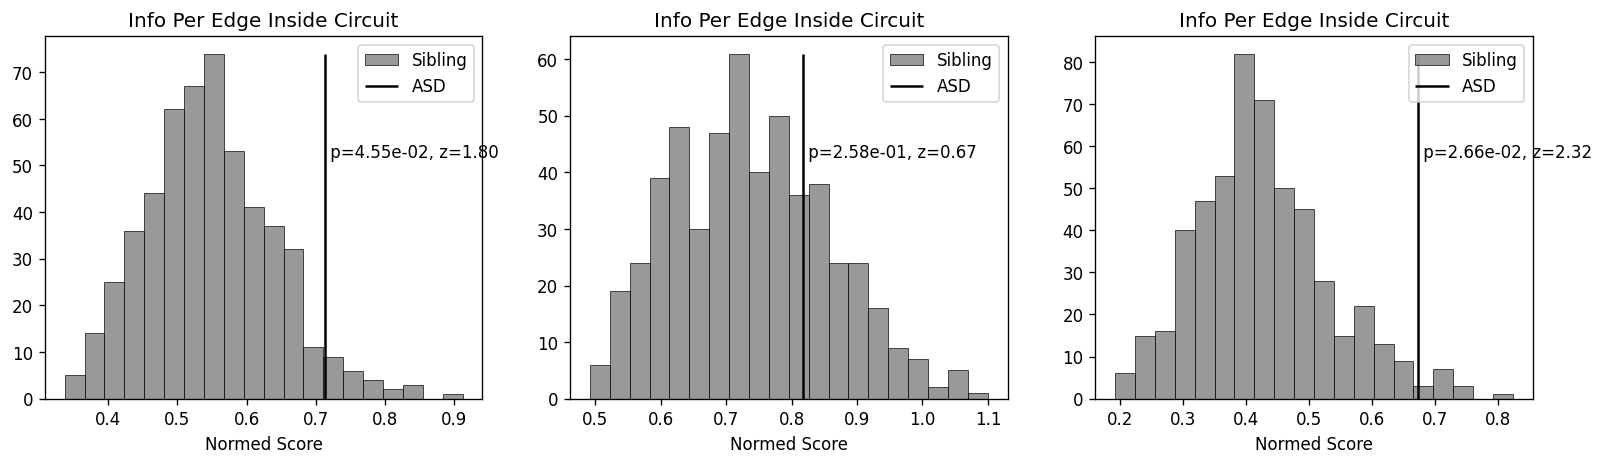

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")

In [43]:
print(len(SCORES_Long))

526


### Distance K-S Test

In [50]:
top46_asd_strs = ASD_BiasDF.head(46).index.values

In [52]:
def MaskDistMat(Mat1, Mat2, cutoff, m='lt'):
    New_Mat2 = Mat2.copy(deep=True)
    for STR_i in Mat1.index.values:
        for STR_j in Mat1.columns.values:
            if m == 'gt':
                if Mat1.loc[STR_i, STR_j] >= cutoff:
                    New_Mat2.loc[STR_i, STR_j] = 0
                else:
                    New_Mat2.loc[STR_i, STR_j] = Mat2.loc[STR_i, STR_j]
            elif m == "lt":
                if Mat1.loc[STR_i, STR_j] <= cutoff:
                    New_Mat2.loc[STR_i, STR_j] = 0
                else:
                    New_Mat2.loc[STR_i, STR_j] = Mat2.loc[STR_i, STR_j]
    return New_Mat2

def MaskDistMat_xx(distance_mat, Conn_mat, cutoff, cutoff2, keep='gt'):
    Conn_mat_new = Conn_mat.copy(deep=True)
    distance_mat_new = distance_mat.copy(deep=True)
    for STR_i in distance_mat.index.values:
        for STR_j in distance_mat.columns.values:
            if keep == 'gt':
                if distance_mat.loc[STR_i, STR_j] >= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0
            elif keep == "lt":
                if distance_mat.loc[STR_i, STR_j] <= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0   
            elif keep=="bw":
                if distance_mat.loc[STR_i, STR_j] >= cutoff and distance_mat.loc[STR_i, STR_j] <= cutoff2:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0   
    return Conn_mat_new, distance_mat_new

Cartesian_distancesDF = pd.read_csv("../dat/allen-mouse-conn/Dist_CartesianDistance.csv",
                                   index_col=0)
adj_mat = pd.read_csv(ConnFil, index_col=0)
Cartesian_distances_w_edge = MaskDistMat(adj_mat, Cartesian_distancesDF, cutoff=0)

In [111]:
asd_dists = Cartesian_distances_w_edge.loc[top46_asd_strs, top46_asd_strs].values.flatten()
asd_dists = np.array([x for x in asd_dists if x >0])
asd_weights = adj_mat.loc[top46_asd_strs, top46_asd_strs].values.flatten()
asd_weights = np.array([x for x in asd_weights if x >0])

In [218]:
from scipy import stats

SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"
Pvalues_d = []
Pvalues_d_1side = []
Ts_d = []
Pvalues_w = []
Ts_w = []
for i in range(1, 100, 1):
    for j in range(1, 100, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top46_sib_strs = Sib_BiasDF.head(46).index.values
        sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_dists = np.array([x for x in sib_dists if x >0])
        t, p = stats.ks_2samp(asd_dists, sib_dists)
        Ts_d.append(t)
        Pvalues_d.append(p)
        t, p = stats.ks_2samp(asd_dists, sib_dists, 'less')
        Pvalues_d_1side.append(p)
        
        sib_weights = adj_mat.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_weights = np.array([x for x in sib_weights if x >0])
        t, p = stats.ks_2samp(asd_weights, sib_weights)
        Ts_w.append(t)
        Pvalues_w.append(p)

Text(0.5, 0, '-log10(p)')

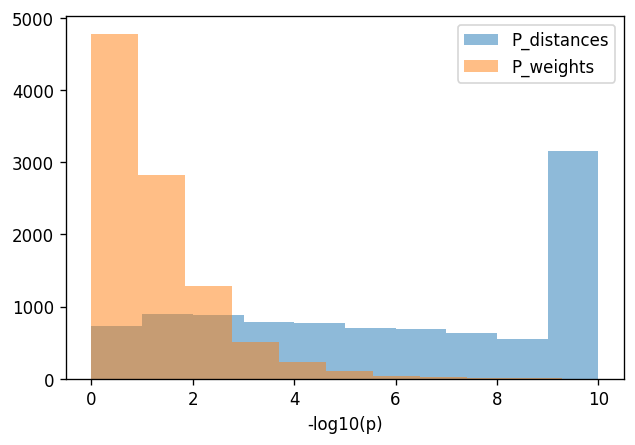

In [219]:
plt.figure(dpi=120)
plt.hist(-np.log10(np.array(Pvalues_d)+1e-10), label="P_distances", alpha=0.5)
plt.hist(-np.log10(np.array(Pvalues_w)+1e-10), label="P_weights", alpha=0.5)
plt.legend()
plt.xlabel("-log10(p)")
#plt.hist(Pvalues)

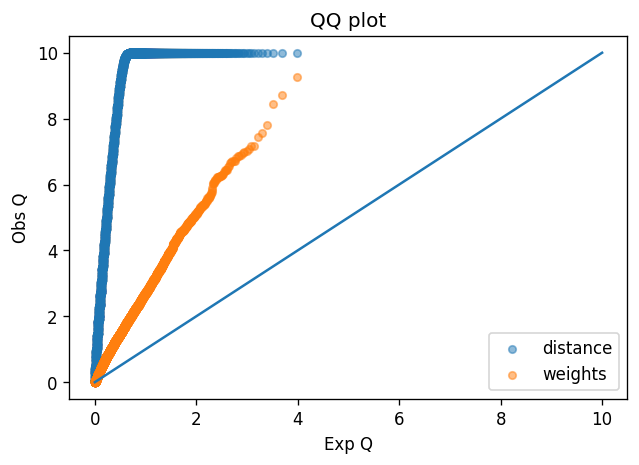

In [220]:
QQplot([np.array(Pvalues_d)+1e-10, np.array(Pvalues_w)+1e-10], 
      ["distance", "weights"])

In [222]:
np.sum(np.array(Pvalues_d)>0.05)

986

In [223]:
np.sum(np.array(Pvalues_w)>0.05)

6176

(array([4.787e+03, 2.828e+03, 1.284e+03, 5.030e+02, 2.270e+02, 1.130e+02,
        3.600e+01, 1.700e+01, 3.000e+00, 3.000e+00]),
 array([1.16500087e-06, 9.27336500e-01, 1.85467183e+00, 2.78200717e+00,
        3.70934250e+00, 4.63667784e+00, 5.56401317e+00, 6.49134851e+00,
        7.41868384e+00, 8.34601918e+00, 9.27335451e+00]),
 <BarContainer object of 10 artists>)

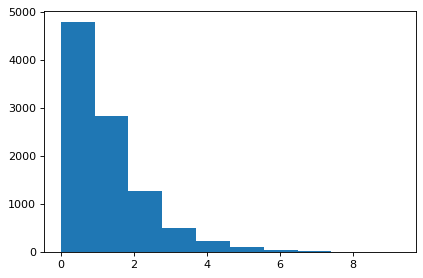

In [115]:
plt.hist(-np.log10(np.array(Pvalues_w)+1e-10))

In [110]:
-np.log10(0.05/100000)

6.301029995663981

In [118]:
i, j = 1,3
biasdf = "cont.bias.{}.{}.csv".format(i,j)
Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
top46_sib_strs = Sib_BiasDF.head(46).index.values
sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
sib_dists = np.array([x for x in sib_dists if x >0])

(array([1.88642496e-04, 3.63810528e-04, 2.62752048e-04, 2.35803120e-04,
        1.41481872e-04, 9.43212480e-05, 6.73723200e-06, 6.73723200e-06,
        6.73723200e-06, 1.34744640e-05]),
 array([ 333.5416016 , 1090.83195701, 1848.12231242, 2605.41266783,
        3362.70302324, 4119.99337865, 4877.28373406, 5634.57408947,
        6391.86444488, 7149.15480029, 7906.44515569]),
 <BarContainer object of 10 artists>)

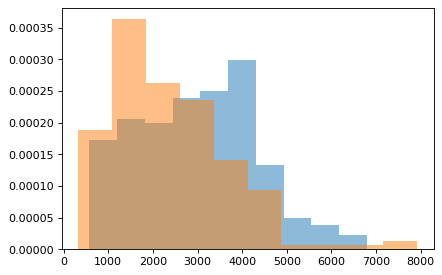

In [119]:
plt.hist(asd_dists, density=1, alpha=0.5)
plt.hist(sib_dists, density=1, alpha=0.5)

#### select and teset

In [146]:
# select best fit sibling
from scipy import stats

SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"
All_Sib_d = []
All_Sib_w = []
for i in range(1, 100, 1):
    for j in range(1, 100, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top46_sib_strs = Sib_BiasDF.head(46).index.values
        sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_dists = np.array([x for x in sib_dists if x >0])
        All_Sib_d.extend(sib_dists)
        sib_weights = adj_mat.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_weights = np.array([x for x in sib_weights if x >0])
        All_Sib_w.extend(sib_weights)

In [147]:
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"
Pvalues_d = []
Ts_d = []
Pvalues_w = []
Ts_w = []
ii, jj = 0,0
min_t = 1000
for i in range(1, 100, 1):
    for j in range(1, 100, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top46_sib_strs = Sib_BiasDF.head(46).index.values
        sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_dists = np.array([x for x in sib_dists if x >0])
        t, p = stats.ks_2samp(All_Sib_d, sib_dists)
        if t < min_t:
            ii = i
            jj = j
            min_t = t
        

In [155]:
biasdf = "cont.bias.{}.{}.csv".format(ii,jj)
Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
top46_sib_strs = Sib_BiasDF.head(46).index.values
sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
sib_dists = np.array([x for x in sib_dists if x >0])
t, p = stats.ks_2samp(All_Sib_d, sib_dists)
print(t, p)
t, p = stats.ks_2samp(asd_dists, sib_dists)
print(t, p)
t, p = stats.ks_2samp(asd_dists, All_Sib_d)
print(t, p)

0.02294879340007472 0.9994383299059365
0.2297872340425532 1.6557121637061911e-06
0.23377527949699994 2.0173943736052894e-14


In [157]:
m = len(asd_dists)
n = len(sib_dists)
1.949 * np.sqrt((n+m)/(n*m))

0.17106397549571656

In [158]:
m = len(asd_dists)
n = len(All_Sib_d)
1.949 * np.sqrt((n+m)/(n*m))

0.11445706341462066

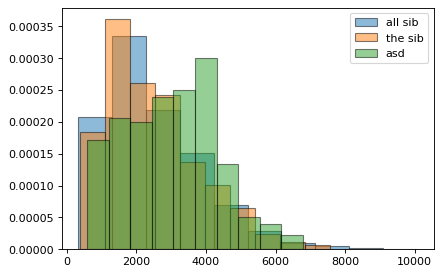

In [149]:
plt.hist(All_Sib_d, density=1, alpha=0.5, label="all sib", edgecolor="black")
plt.hist(sib_dists, density=1, alpha=0.5, label="the sib", edgecolor="black")
plt.hist(asd_dists, density=1, alpha=0.5, label="asd", edgecolor="black")
plt.legend()

In [152]:
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"
Pvalues_d = []
Ts_d = []
Pvalues_w = []
Ts_w = []
ii_w, jj_w = 0,0
min_t = 1000
for i in range(1, 100, 1):
    for j in range(1, 2, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top46_sib_strs = Sib_BiasDF.head(46).index.values
        sib_weights = adj_mat.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_weights = np.array([x for x in sib_weights if x >0])
        t, p = stats.ks_2samp(All_Sib_w, sib_weights)
        Ts_w.append(t)
        Pvalues_w.append(p)
        if t < min_t:
            ii_w = i
            jj_w = j
            min_t = t

In [153]:
biasdf = "cont.bias.{}.{}.csv".format(ii_w,jj_w)
Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
top46_sib_strs = Sib_BiasDF.head(46).index.values
sib_weights = adj_mat.loc[top46_sib_strs, top46_sib_strs].values.flatten()
sib_weights = np.array([x for x in sib_weights if x >0])
t, p = stats.ks_2samp(All_Sib_w, sib_weights)
print(t, p)
t, p = stats.ks_2samp(asd_weights, sib_weights)
print(t, p)

0.031688695739574224 0.8556359339215986
0.065304145679969 0.4771976603575262


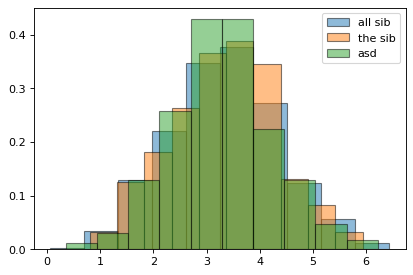

In [154]:
plt.hist(All_Sib_w, density=1, alpha=0.5, label="all sib", edgecolor="black")
plt.hist(sib_weights, density=1, alpha=0.5, label="the sib", edgecolor="black")
plt.hist(asd_weights, density=1, alpha=0.5, label="asd", edgecolor="black")
plt.legend()

44.70973523867436

#### Test against connectome

In [166]:
all_edge_dist = Cartesian_distances_w_edge.values.flatten()
all_edge_dist = [x for x in all_edge_dist if x >0]
all_edge_weights = adj_mat.values.flatten()
all_edge_weights = [x for x in all_edge_weights if x >0] 

In [174]:
t, p = stats.ks_2samp(asd_dists, all_edge_dist, "less")
print(t, p)
t, p = stats.ks_2samp(asd_weights, all_edge_weights, "less")
print(t, p)

0.09101505585235552 0.010533991912571136
0.053472559494900436 0.20447885376304892


In [186]:
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"
Pvalues_d = []
Ts_d = []
Pvalues_w = []
Ts_w = []
for i in range(1, 100, 1):
    for j in range(1, 100, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top46_sib_strs = Sib_BiasDF.head(46).index.values
        sib_dists = Cartesian_distances_w_edge.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_dists = np.array([x for x in sib_dists if x >0])
        t, p = stats.ks_2samp(sib_dists, all_edge_dist, "less")
        #t, p = stats.ks_2samp(sib_dists, all_edge_dist)
        Ts_d.append(t)
        Pvalues_d.append(p)
        
        """
        sib_weights = adj_mat.loc[top46_sib_strs, top46_sib_strs].values.flatten()
        sib_weights = np.array([x for x in sib_weights if x >0])
        t, p = stats.ks_2samp(sib_weights, all_edge_weights, "less")
        #t, p = stats.ks_2samp(sib_weights, all_edge_weights)
        Ts_w.append(t)
        Pvalues_w.append(p)
        """

/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7265: RuntimeWarning: overflow encountered in double_scalars
  term = B[j] * bin
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: RuntimeWarning: overflow encountered in double_scalars
  num_paths += term
/home/jw3514/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:7268: Runt

In [ ]:
plt.figure(dpi=120)
plt.hist(-np.log10(np.array(Pvalues_d)+1e-10), label="P_distances", alpha=0.5)
plt.hist(-np.log10(np.array(Pvalues_w)+1e-10), label="P_weights", alpha=0.5)
plt.legend()
plt.xlabel("-log10(p)")
#plt.hist(Pvalues)

In [ ]:
QQplot([np.array(Pvalues_d)+1e-10, np.array(Pvalues_w)+1e-10], 
      ["distance", "weights"])

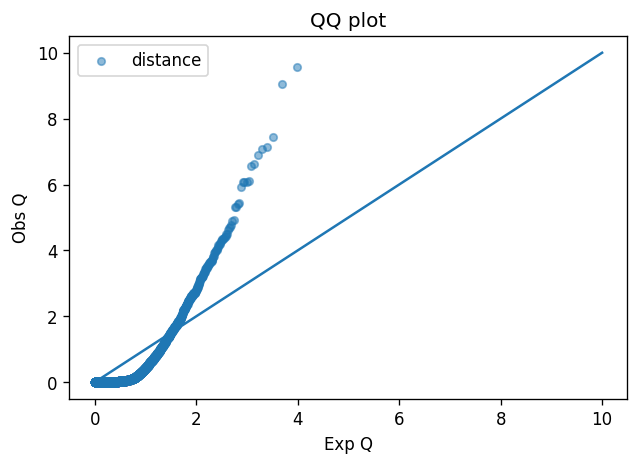

In [187]:
QQplot([np.array(Pvalues_d)+1e-10,], 
      ["distance"])

In [190]:
sum(np.array(Pvalues_d)<0.010533991912571136)

192

In [192]:
sum(np.array(Pvalues_d)>0.05)

9426

In [191]:
192 / 10000

0.0192

In [196]:
topN = np.arange(10, 200, 20)

In [208]:
#for top in topN:
for top in [46]:
    top_asd_strs = ASD_BiasDF.head(top).index.values
    asd_dists = Cartesian_distances_w_edge.loc[top_asd_strs, top_asd_strs].values.flatten()
    asd_dists = np.array([x for x in asd_dists if x >0])
    t, p = stats.ks_2samp(asd_dists, all_edge_dist, "less")
    print("%d\t%.3f\t%.2e"%(top, t, p))

46	0.091	1.05e-02


In [209]:
#All_Sib_d
#stats.ks_2samp(All_Sib_d, all_edge_dist, "less")
stats.ks_2samp(All_Sib_d, all_edge_dist, "less")

KstestResult(statistic=0.0, pvalue=1.0)

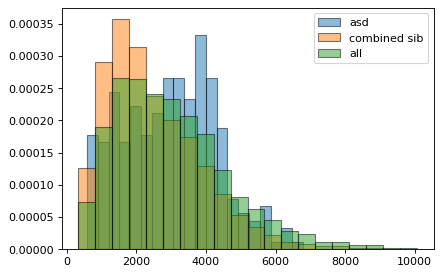

In [211]:
plt.hist(asd_dists, bins=20, density=1, alpha=0.5, label="asd", edgecolor="black")
plt.hist(All_Sib_d,  bins=20, density=1, alpha=0.5, label="combined sib", edgecolor="black")
plt.hist(all_edge_dist,  bins=20, density=1, alpha=0.5, label="all", edgecolor="black")
plt.legend()

In [212]:
top = 46
top_asd_strs = ASD_BiasDF.head(top).index.values
asd_dists = Cartesian_distances_w_edge.loc[top_asd_strs, top_asd_strs].values.flatten()
asd_dists = np.array([x for x in asd_dists if x >0])
mean_asd_dist = np.mean(asd_dists)
print(mean_asd_dist)

2980.3189348539336


In [213]:
Mean_of_sibs = []
for i in range(1, 100, 1):
    for j in range(1, 100, 1):
        biasdf = "cont.bias.{}.{}.csv".format(i,j)
        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR+biasdf, index_col="STR")
        top_asd_strs = Sib_BiasDF.head(top).index.values
        sib_dists = Cartesian_distances_w_edge.loc[top_asd_strs, top_asd_strs].values.flatten()
        sib_dists = np.array([x for x in sib_dists if x >0])
        #t, p = stats.ks_2samp(sib_dists, all_edge_dist, "less")
        #t, p = stats.ks_2samp(sib_dists, all_edge_dist)
        Mean_of_sibs.append( np.mean(sib_dists))

No handles with labels found to put in legend.


<AxesSubplot:>

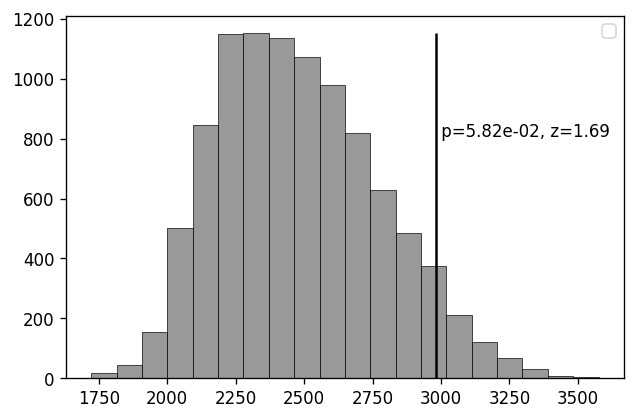

In [217]:
fig, ax = plt.subplots(dpi=120)
PlotPermutationP(Mean_of_sibs, mean_asd_dist, ax,)

In [262]:
300000 / 7 / 24

1785.7142857142856

In [19]:
def oddr(De,He,Dn,Hn):
    return (De/He) / (Dn/Hn)

In [ ]:
oddr(15, 3, 24000, 97000)